<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/Copy_of_LSTMStock_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
!pip install -q yfinance

In [63]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader.data import DataReader
import yfinance as yf
import os
import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import numpy as np
import altair as alt  
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [64]:
#Import Data 
stockTypes = ['TSLA','AAPL', 'GOOG', 'MSFT', 'AMZN']

#Import from file
#stockDf = pd.read_csv('AAPL.csv',delimiter=',') 

#Import from API
end = dt.now()
start = dt(end.year - 2, end.month, end.day)
for stockDf in stockTypes:
    globals()[stockDf] = yf.download(stockDf, start, end)

#Add Name
stocks = [TSLA, AAPL, GOOG, MSFT, AMZN]
company_name = ["TESLA", "APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for stock, name in zip(stocks, company_name):
    stock["company_name"] = name

#Additional Columns
for stock in stocks:
    stock['openChange'] = stock.Open.pct_change()
    stock['closeChange'] = stock.Close.pct_change()
    #stock['month'] = pd.DatetimeIndex(stock['Date']).month
    #stock['day'] = pd.DatetimeIndex(stock['Date']).day
    #stock['year'] = pd.DatetimeIndex(stock['Date']).year
    #stock['display'] = stock["month"].map(str)+ "-" + stock["year"].map(str)

# Select features (columns) to be involved intro training and predictions
cols = list(stocks[1])[0:1]
#cols.pop(1) #Delete middle column

print('Training set shape == {}'.format(stocks[1].shape))
print('Featured selected: {}'.format(cols))

print(AAPL[1:5])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape == (506, 9)
Featured selected: ['Open']
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2020-04-30  72.489998  73.632500  72.087502  73.449997  72.454399  183064000   
2020-05-01  71.562500  74.750000  71.462502  72.267502  71.287926  240616800   
2020-05-04  72.292503  73.422501  71.580002  73.290001  72.296562  133568000   
2020-05-05  73.764999  75.250000  73.614998  74.389999  73.381645  147751200   

           company_name  openChange  closeChange  
Date                                              
2020-04-30   

In [65]:
TSLA.describe()

,Open,High,Low,Close,Adj Close,Volume,openChange,closeChange
count,506.000000,506.000000,506.000000,506.000000,506.000000,5.060000e+02,505.000000,505.000000
mean,667.437882,682.676836,650.731914,667.269741,667.269741,3.942097e+07,0.004433,0.004217
std,269.563511,275.498179,262.576355,268.787000,268.787000,2.674938e+07,0.044267,0.040939
min,140.199997,152.399994,136.608002,140.264008,140.264008,9.800600e+06,-0.156610,-0.210628
25%,440.092499,448.882507,426.969994,440.155006,440.155006,2.227335e+07,-0.017180,-0.019348
50%,684.440002,697.065002,668.875000,681.489990,681.489990,3.048760e+07,0.003116,0.002600
75%,855.000000,873.622498,837.527496,854.619995,854.619995,4.661348e+07,0.028095,0.024444
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,2.221262e+08,0.188395,0.196412


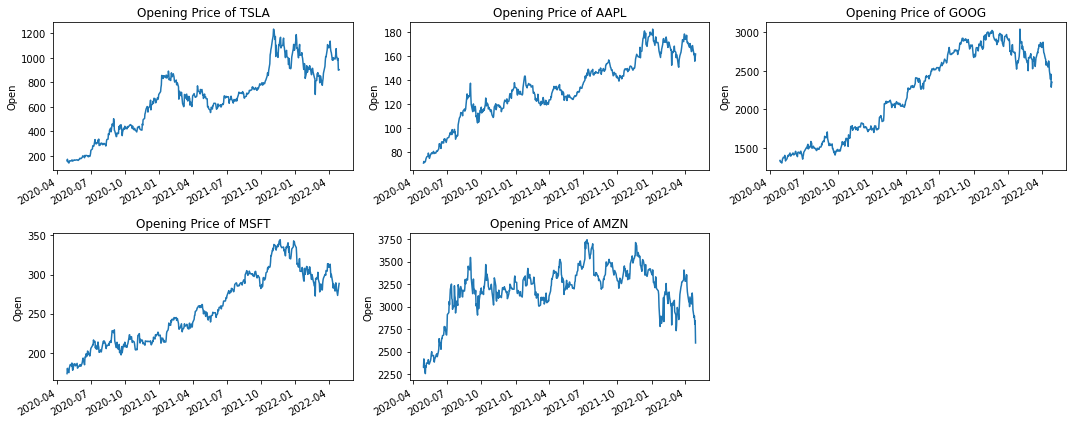

In [66]:
#Opening Graph
mplot.figure(figsize=(15, 6))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Open'].plot()
    mplot.ylabel('Open')
    mplot.xlabel(None)
    mplot.title(f"Opening Price of {stockTypes[i - 1]}")
    
mplot.tight_layout()

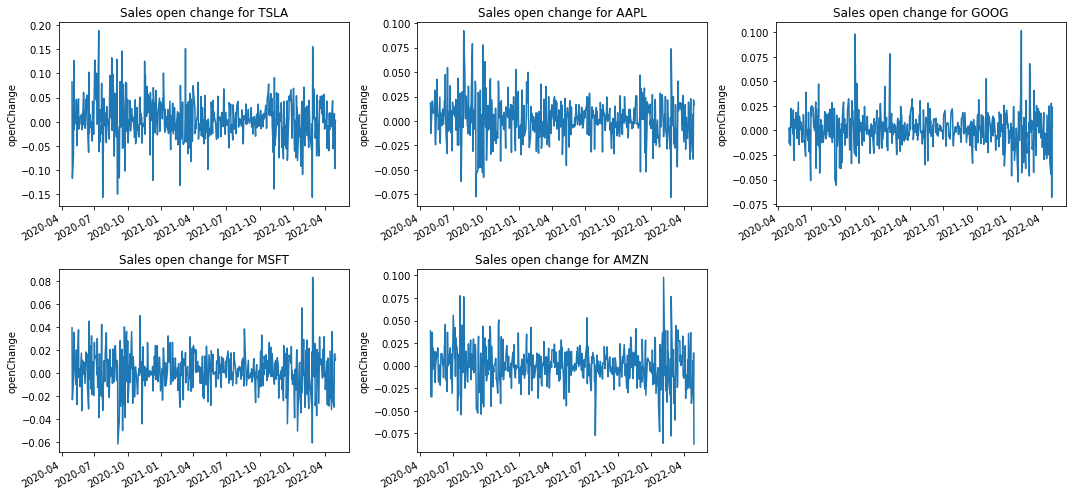

In [67]:
#Change Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['openChange'].plot()
    mplot.ylabel('openChange')
    mplot.xlabel(None)
    mplot.title(f"Sales open change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

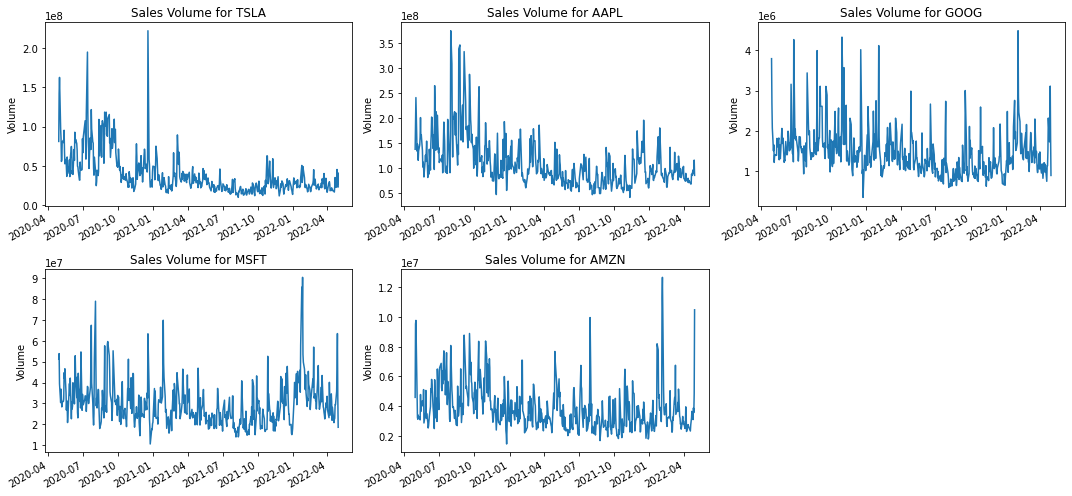

In [68]:
#Volume Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Volume'].plot()
    mplot.ylabel('Volume')
    mplot.xlabel(None)
    mplot.title(f"Sales Volume for {stockTypes[i - 1]}")
    
mplot.tight_layout()

In [69]:
#Get Desired columns to train
stockDf = stocks[1]
print('Featured selected: {}'.format(cols))
stockDf = stockDf[cols].astype(str)
for i in cols:
    for j in range(0, len(stockDf)):
        stockDf[i][j] = stockDf[i][j].replace(',', '')

stockDf = stockDf.astype(float)

# Using multiple features (predictors) 
fromRecord = 50
toRecord = 100
#newDf = stockDf.loc[fromRecord:toRecord] 
newDf = stockDf[fromRecord:toRecord]
myDs = newDf.to_numpy() 
myDs = myDs.astype('float32')
print('Shape of training set == {}.'.format(newDf.shape))
newDf[1:5]

Featured selected: ['Open']
Shape of training set == (50, 1).


,Open
Date,
2020-07-13,97.264999
2020-07-14,94.839996
2020-07-15,98.989998
2020-07-16,96.562500


In [70]:
#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]


In [71]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

#Reshape data to normalize it [samples, time steps, features]
print("take 1")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))
print("take 2")
print('X_Train[0] (Samples): ' + str(X_train.shape[0]))
print('X_Train[1] (Features): ' + str(X_train.shape[1]))

take 1
X_Train[0] (Samples): 29
X_Train[1] (Features): 5
take 2
X_Train[0] (Samples): 29
X_Train[1] (Features): 1


In [72]:
#Parameters
verboseAmt = 1
epochCnt = 100
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = True

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/100
6/6 [==============================] - 20s 920ms/step - loss: 0.1583 - val_loss: 0.3704
Epoch 2/100
6/6 [==============================] - 0s 27ms/step - loss: 0.1458 - val_loss: 0.3474
Epoch 3/100
6/6 [==============================] - 0s 26ms/step - loss: 0.1329 - val_loss: 0.3213
Epoch 4/100
6/6 [==============================] - 0s 30ms/step - loss: 0.1182 - val_loss: 0.2911
Epoch 5/100
6/6 [==============================] - 0s 24ms/step - loss: 0.1037 - val_loss: 0.2556
Epoch 6/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0831 - val_loss: 0.2137
Epoch 7/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0664 - val_loss: 0.1654
Epoch 8/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0474 - val_loss: 0.1138
Epoch 9/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0369 - val_loss: 0.0691
Epoch 10/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0307 - val_loss: 0.0383
Epoch 11/100
6/6 

In [73]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [74]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('X Train Shape' + str(X_train.shape))
print('Y Train Shape' + str(Y_train.shape))
print('X Test Shape' + str(X_test.shape))
print('Y Test Shape' + str(Y_test.shape))
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:' + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))

X_train: 29
X_test: 29
Y_train: 1
Y_test: 1
X Train Shape(29, 1, 5)
Y Train Shape(1, 29)
X Test Shape(29, 1, 5)
Y Test Shape(1, 29)
train_predict: 29
Y_trained_predict: 29
test_predict: 29
Y_test_predict: 29
Shape of Y_train:1
Shape of Y_train:1
Shape of Y_train:1
Shape of Y_train:1


In [75]:
#inverse the inverse
Y_trained_predict = scaler.inverse_transform(train_predict)
Y_test_predict = scaler.inverse_transform(test_predict)

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]
Y_test = Y_test.reshape(s2,s1)
s1 = Y_train.shape[0]
s2 = Y_train.shape[1]
Y_train = Y_train.reshape(s2,s1)

In [76]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
2.5997203159092788 

Test RMSE is: 
2.748862410691959


In [77]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)
result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

,Actual_Y,Predicted_Y
0,96.562498,97.200760
1,96.987501,97.293495
2,96.417500,96.882072
3,99.172504,97.936447
4,96.692495,97.477890


Text(0, 0.5, 'Value of Stock')

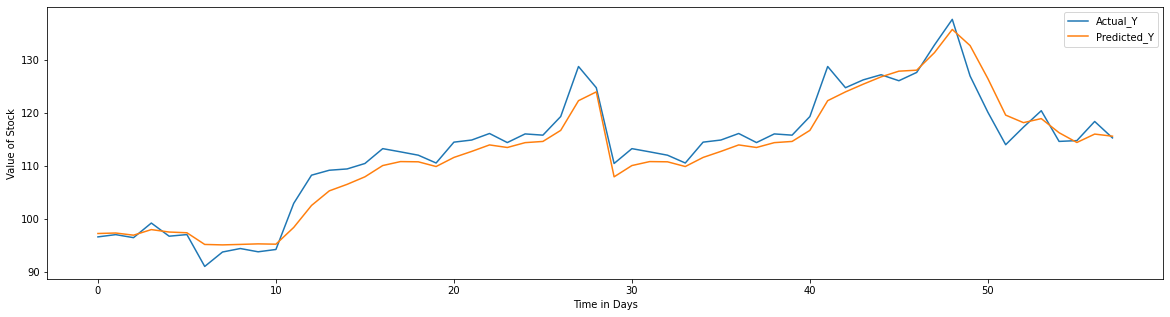

In [78]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')

In [79]:
#Run ME

predictionCount = 30
lookback = 15

predictMeData = stockDf[-lookback:] 
predictionDs = predictMeData.to_numpy() 
predictionDs = predictionDs.astype('float32')

predictionDs = np.reshape(predictionDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
predictionDs = scaler.fit_transform(predictionDs)  
X = predictionDs[0:lookback,:]
XX, YY = batchData(X, batchSize, "L")
XX = np.reshape(XX, (XX.shape[0], timeSteps, XX.shape[1]))
out = model.predict(XX)
out

array([[0.90345806],
       [0.69772476],
       [0.6163782 ],
       [0.71218246],
       [0.8036982 ],
       [0.7151944 ],
       [0.49848646],
       [0.42965972],
       [0.20487753]], dtype=float32)